## Neo4j

## Short intro to graph theory

To understand Neo4j you need some intuition to graph theory.

Graph theory is the study of graphs (usually called networks in our domain). Graphs are mathematical structures used to model pairwise relations (edges) between object(nodes). A graph can be either undirected (symetrical relation) or directed (asymetrical realtion). An edge connects only two nodes (It can be twice the same node). Here's an example of a graph:

<img src="./img/network.png">

A network can be represented in the three following format:

### Adjacency matrix
A network can be represented as an adjacency matrix. The row names and col names of this matrix is the names of the node. The cells are the relation between nodes. This matrix is symetric if the network is undirected. If directed the rows are the starting point of the edge (also called "source") and the columns are the end ("target"). Here's the adjacency matrix for the previous network:

/  | Spider-man | Nick Fury | Capitain America | Iron man | 
--- | --- | --- | --- | --- |
Spider-man | 0 | 0 | 0 | 0 |
Nick Fury | 1 | 0 | 0 | 0 |
Capitain America | 1 | 1 | 0 | 1 |
Iron man | 1 | 1 | 0 | 0 |

### Edge list

An edge list is composed of three columns: A source, a target and a weight. In others words we focus on the edge instead of the node. A source is the node from which the edge is going out and the target the node where the edge comes in. Here's the edge list of the previous network:

| Source | Target | Weight | 
| --- | --- | --- |
| Nick Fury | Spider-man | 1 |
| Capitain America | Spider-man | 1 |
| Capitain America | Nick Fury | 1 |
| Capitain America | Iron man | 1 |
| Iron man | Spider-man | 1 |
| Iron man | Nick Fury | 1 |

### Incidence matrix

An incidence matrix is probably the less used format. It's a matrix where the columns are the edges and the rows the nodes.


/  | edge 1 | edge 2 | edge 3 | edge 4 | edge 5 | edge 6 | 
--- | --- | --- | --- | --- | --- | --- |
Spider-man | 0 | -1 | 0 | 0 | -1 | -1 |
Nick Fury | -1 | 0 | 0 | -1 | 0 | 1 |
Capitain America | 1 | 1 | 1 | 0 | 0 | 0 |
Iron man | 0 | 0 | -1 | 1 | 1 | 0 |


## Neo4j DB

The last chapter we worked on a document store architecture noSQL DB. Now we will focus our attention on a graph database.
If you followed the instructions of the readme you should be able to do the next steps.

If you use neo4j desktop the procedure is easy Let's start by creating a new project with the password "password_tuts". the default user and collection name is "neo4j"


In [9]:
import py2neo

# Connect to graph db , default user is neo4j and default collection is neo4j
# to change default auth just go to the localhost

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="neo4j")
graph.delete_all()


In order to change the name of the DB you are working on run the following in the neo4j console

```
create database tutorial
:use tutorial
``` 

In [5]:
# First steps in py2neo

import py2neo

# Connect to graph db , default is auth=("neo4j", "neo4j")
# to change default auth just go to the localhost

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="tutorial")
#graph.delete_all()
# Node method: first argument is Node label and then arbitrary number of characteristics
Person1 = py2neo.Node("Person", name="Person1", age = 25, hobbies = "foot") 
Person2 = py2neo.Node("Person", name="Person2", age = 27)
Person3 = py2neo.Node("Person", name="Person3", age = 24)

ab = py2neo.Relationship(Person1, "COLLABORATED", Person2, n_collab = 3)
ba = py2neo.Relationship(Person2, "COLLABORATED", Person1, n_collab = 2)
# You need to commit these node before they appear in the db
# We will do that by using a transaction


transaction = graph.begin()
transaction.create(Person1|Person2|Person3)
transaction.create(ab)
transaction.create(ba)
graph.commit(transaction)

print(graph.exists(ab))



True


You can also create your own class of node type with specific argument (more structured).

In [6]:
import py2neo
from py2neo import ogm
import numpy as np
import tqdm

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="tutorial")
# Delete every node and relation
graph.delete_all()

# The class Person will inherit from ogm.GraphObject
class Person(ogm.GraphObject):
    __primarykey__ = "id_"
    
    id_ = ogm.Property()
    name = ogm.Property()
    age = ogm.Property()
    
    def __init__(self):
        self.node = self.__ogm__.node

# Init dict with the different name for random attribution     
names = {"0":"Person1",
        "1":"Person2",
        "2":"Person3"}
# Init the transaction or you will insert every node one by one which is really slow.
transaction = graph.begin()
iteration = 0
for i in tqdm.tqdm(range(1000)):
    # Create instance of class
    ind = Person()
    # Init variable of ind
    ind.id_ = int(iteration)
    name = names[str(np.random.random(3).argmax())]
    ind.name = name
    ind.age = int(np.random.randint(low=20, high=60, size=1)[0])
    
    # init transaction  
    transaction.create(ind.node)
    iteration += 1
    
    # commit transaction and reset it every 1000 iterations
    if (i+1) % 1000 == 0:
        transaction.commit()
        transaction = graph.begin()

 99%|█████████▉| 991/1000 [00:09<00:00, 82.61it/s] C:\Users\ndubo\AppData\Local\Temp\ipykernel_9740\164765476.py:43: DeprecationWarning: The transaction.commit() method is deprecated, use graph.commit(transaction) instead
  transaction.commit()
100%|██████████| 1000/1000 [00:10<00:00, 97.92it/s]


Works pretty well but it is pretty slow. To overcome this problem you can use Cypher queries. Cypher is Neo4j’s graph query language and is way faster than the py2neo wrapper. Cypher is, like SQL, a declarative, textual query language, but for graphs. If you have a small project you can ignore Cypher queries but if you are indeed interested by neo4j I really recommend to learn Cypher queries. We will learn CRUD operation with Cypher queries. https://neo4j.com/docs/cypher-refcard/current/.

### CREATE

In [7]:
import tqdm
import py2neo
import numpy as np
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="tutorial")
graph.delete_all()

names = {"0":"Person1",
        "1":"Person2",
        "2":"Person3"}

# Execute a query with graph.run
# Here the query creates a "constraint" on the id_ of the person asking for it to be unique i.e Primary key
try:
    graph.run("CREATE CONSTRAINT ON (:Person) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")
    
# init a list of transaction that we will commit at the same time
transaction_list = []

iteration = 0
for i in tqdm.tqdm(range(100000)):
    id_ = iteration
    name = names[str(np.random.random(3).argmax())]
    age = int(np.random.randint(low=20, high=60, size=1)[0])
    # Append a dict, 1 dict per person 
    transaction_list.append({"id_":id_,"name":name,"age":age})
    iteration += 1
    if i % 1000 == 0:
        # To commit a list of transaction with cypher you can use the UNWIND parameter
        # $json => json will be the argument of run with the data
        transaction = "UNWIND $json as data CREATE (n:Person) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

graph.run(transaction, json=transaction_list)

# CREATE Relation

# MATCH search for the pattern described in it
# WHERE = condition
# CREATE an edge (node)-[:Relationtype]-(node2)

for i in range(10):
    query = """MATCH (a:Person),(b:Person)
    WHERE a.id_ = {} AND b.id_ = {}
    CREATE (a)-[r:COLLAB]->(b)
    """.format(str(i),str(i+1))
    graph.run(query)

for i in range(21,25,1):
    query = """MATCH (a:Person),(b:Person)
    WHERE a.id_ = %s AND b.id_ = %s
    CREATE (a)-[:COLLAB {n_collab: %s}]->(b)
    """% (str(i),str(i+1),2)
    graph.run(query)
    

transaction_list = []
    
for i in range(20,40,1):
    transaction_list.append({"id_1":i,"id_2":(i+1), "n_collab":i*2})
    
transaction = """UNWIND $json as data
MATCH (a:Person),(b:Person)
WHERE a.id_ = data.id_1 AND b.id_ = data.id_2
CREATE (a)-[:COLLAB {n_collab: data.n_collab}]->(b)
"""
graph.run(transaction, json=transaction_list)
pass
# You can't create an undirected edge but you can have the notion of undirected edges at query time.    

Constraint already exists


100%|██████████| 100000/100000 [00:11<00:00, 8380.43it/s]


### READ

In [8]:
# READ

import tqdm
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="tutorial")

# RETURN returns variable specified

# Count number of observation (n_node) with label Person.
query = """
MATCH(person:Person)
WITH count(person) AS n_node
RETURN n_node
"""
data = graph.run(query)
n_node = next(data)["n_node"]
print(n_node)

# Return every node with Label Person
query = """
MATCH(person:Person)
RETURN person.name AS name, person.age AS age, person.id_ as id_
"""

# Returns a generator
data = graph.run(query)

#iterate through all elements
iteration = 0
pbar = tqdm.tqdm(total=n_node)

for i in data:
    iteration += 1
    if iteration == n_node:
        print(data["name"])
        print(data["age"])
        print(data["id_"])
    pbar.update(1)

# print last element


100000


 99%|█████████▊| 98515/100000 [00:00<00:00, 164696.99it/s]

Person3
59
99999


100%|██████████| 100000/100000 [00:19<00:00, 164696.99it/s]

### UPDATE

In [19]:
## update
#

query = """
    MATCH (person:Person) 
    WHERE person.id_ < 10
    SET person.newobs = %s
    RETURN person.id_, person.newobs
    """ % (43)

df = graph.run(query).to_data_frame()
print(df)

   person.id_  person.newobs
0           0             43
1           1             43
2           2             43
3           3             43
4           4             43
5           5             43
6           6             43
7           7             43
8           8             43
9           9             43


### DELETE

In [20]:
# Delete
# DETACH to remove edges then DELETE the node
query = """
    MATCH (person:Person) 
    WHERE person.id_ < 10
    DETACH DELETE person
    """ 

graph.run(query)
pass

### A study case

To become more familiar with neo4j we will convert a csv file to a network and do some stats using cypher queries. The data can be found [here](https://www.kaggle.com/dannielr/marvel-superheroes?select=characters.csv) and I stored it in the folder data in github. First thing to do is to switch the DB. We will call it "MCU". Our goal will be to create a node per character and link them by apperance in a comic (Simple binary graph, if they appeared once in the same comic then a link is created). Finally we give each node different properties (power, stats, ....) and finish by doing some query to see basics stats

In [31]:
# initial creation
import pandas as pd
import tqdm
import py2neo

# pandas to read_csv , header = True
characters = pd.read_csv("data/Chap4/Marvel_Superheroes/characters.csv")
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

graph.delete_all()

# CONSTRAINT if condition (here n.id_ is unique) not respected => error
# If constraint already exists pass (IF NOT EXISTS probably works too)
try:
    graph.run("CREATE CONSTRAINT ON (n:Superhero) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

# Init the list that will contains dicts for each node
transaction_list = []

# iterrows = line by line iterators of the df row[0] = id row[1] = the variables in columns
for row in tqdm.tqdm(characters.iterrows()):
    id_ = row[1]["characterID"]
    name = row[1]["name"]
    transaction_list.append({"id_":id_,"name":name})
    # Commit when list = 1000, vary it depending of the case
    if len(transaction_list) == 1000:
        # UNWIND = split the list given to it (here $json because json=transaction_list)
        # For each dict do the following query CREATE (n:Superhero) SET n = data
        transaction = "UNWIND $json as data CREATE (n:Superhero) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

# Some observation left (e.g 7700 node, will commit every 100. so 700 left)
graph.run(transaction, json=transaction_list)

#pass

1170it [00:01, 977.60it/s]


(No data)

In [32]:
import pandas as pd
import py2neo

stats = pd.read_csv("data/Chap4/Marvel_Superheroes/characters_stats.csv")
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")


# OPTIONAL MATCH =>  search for the pattern described in it, while using nulls for missing parts of the pattern.
transaction = """UNWIND $json as data
OPTIONAL MATCH (a:Superhero {name:data.Name})
SET a += {Alignement:data.Alignement,Intelligence:data.Intelligence,Strength:data.Strength,Speed:data.Speed,Durability:data.Durability,
         Power:data.Power,Combat:data.Combat,Total:data.Total} 
"""

transaction_list = []

iteration = 0
for row in tqdm.tqdm(stats.iterrows()):
    transaction_list.append(dict(row[1]))
    iteration += 1
    if iteration % 1000 == 0:
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

pass

611it [00:00, 3866.27it/s]


In [33]:
# edges
import pandas as pd
import tqdm
import py2neo
import itertools

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

characters2comics = pd.read_csv("data/Chap4/Marvel_Superheroes/charactersToComics.csv")
characters2comics = characters2comics.drop_duplicates()
transaction_list = []

# MERGE = if pattern does not exists ON CREATE
# If pattern exists do ON MATCH



transaction = """UNWIND $json as data
MATCH (a:Superhero),(b:Superhero)
WHERE a.id_ = data.id_1 AND b.id_ = data.id_2
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for comic in tqdm.tqdm(characters2comics.groupby(["comicID"])):
    related_ids = comic[1]["characterID"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"id_1":sh1,"id_2":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

100%|██████████| 22250/22250 [00:36<00:00, 602.34it/s] 


In [44]:
# Let's see if everything works well
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (a:Superhero{name:'Pepper Potts'})-[r:RELATION]-(b:Superhero{name:'Iron Man'}) RETURN r,a,b"""
data = graph.run(query).to_data_frame()
print(data["r"],data["a"],data["b"])

0    {'n_collab': 136}
Name: r, dtype: object 0    {'name': 'Pepper Potts', 'id_': 1009494}
Name: a, dtype: object 0    {'Speed': 58, 'Intelligence': 100, 'id_': 1009...
Name: b, dtype: object


In [35]:
# Time to do some interesting stats

import seaborn as sns
import py2neo
import pandas as pd

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

# Get every property key and some basic stats

# Get unique keys to init df
query = """MATCH (p:Superhero)
WHERE exists(p.Total)
WITH p, keys(p) as pKeys
UNWIND pKeys as Key
RETURN distinct Key"""

data = graph.run(query).to_data_frame()
df = pd.DataFrame(columns = list(data["Key"]),dtype="int8")


In [43]:
print(data)

      degree
0         74
1        220
2        255
3        117
4        118
...      ...
1165       5
1166       0
1167       2
1168       1
1169       9

[1170 rows x 1 columns]


In [38]:
# For each author append the dict to dataframe
query = """MATCH (p)
WHERE exists(p.Total)
RETURN p"""
data = graph.run(query).to_data_frame()
for node in data["p"]:
    df = df.append(dict(node), ignore_index=True)
    
print(df.loc[:,"Durability":"Combat"])    

AttributeError: 'DataFrame' object has no attribute 'append'

In [39]:
rows = []

for node in data["p"]:
    rows.append(dict(node))

new_df = pd.DataFrame(rows)

df = pd.concat([df, new_df], ignore_index=True)


     Durability  Strength  Power  Speed  Intelligence  Combat  Total      id_  \
0            56        19     46     35            63     100    319  1009220   
1            65        32     60     35            56      84    332  1010740   
2            42        11     25     23            75     100    276  1009471   
3            28        16     22     23            50     100    239  1009515   
4            14        10     19     12            75      80    210  1009535   
..          ...       ...    ...    ...           ...     ...    ...      ...   
192          14         5     62     12            25      14    132  1011092   
193          35        48     54     42            50      60    289  1011071   
194           1         1      0      1             1       1      5  1009248   
195          80        80     84     33            63      84    424  1011073   
196          80        32     38     45            63      65    323  1011349   

                name  
0   

In [40]:
print(df)

     Durability  Strength  Power  Speed  Intelligence  Combat  Total      id_  \
0            56        19     46     35            63     100    319  1009220   
1            65        32     60     35            56      84    332  1010740   
2            42        11     25     23            75     100    276  1009471   
3            28        16     22     23            50     100    239  1009515   
4            14        10     19     12            75      80    210  1009535   
..          ...       ...    ...    ...           ...     ...    ...      ...   
192          14         5     62     12            25      14    132  1011092   
193          35        48     54     42            50      60    289  1011071   
194           1         1      0      1             1       1      5  1009248   
195          80        80     84     33            63      84    424  1011073   
196          80        32     38     45            63      65    323  1011349   

                name  
0   

C:\Users\ndubo\AppData\Local\Temp\ipykernel_15924\194958518.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Strength"])


<Axes: xlabel='Strength', ylabel='Density'>

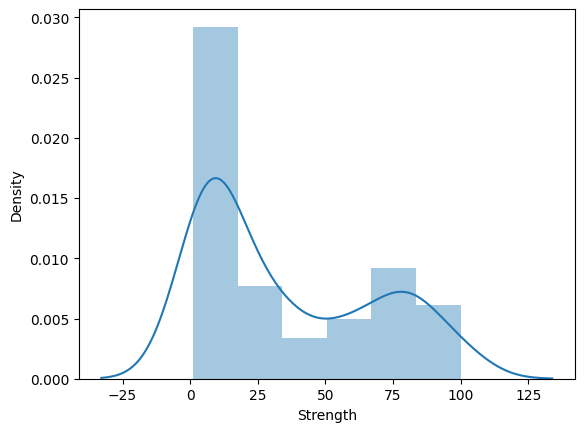

In [21]:
sns.distplot(df["Strength"])

In [42]:
# density of degrees

# The WITH clause allows query parts to be chained together, 
# piping the results from one to be used as starting points or criteria in the next.
# size(()-[:RELATION]->(p)) = number of relation that goes into node p  
query =  """
MATCH (p)
WITH p, size(()-[:RELATION]->(p)) as degree
RETURN degree
"""
data = graph.run(query).to_data_frame()
#ax = sns.distplot(data["degree"],hist=False)
#ax.title.set_text("Density of degrees")
print(data)

      degree
0         74
1        220
2        255
3        117
4        118
...      ...
1165       5
1166       0
1167       2
1168       1
1169       9

[1170 rows x 1 columns]


C:\Users\ndubo\AppData\Local\Temp\ipykernel_15924\1740319014.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data["r.n_collab"],hist=False)


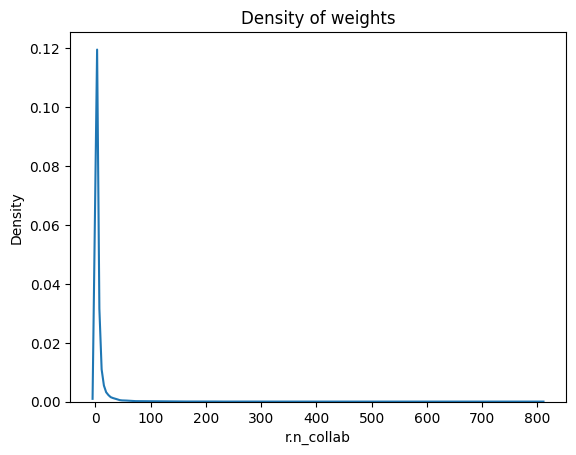

In [23]:
# density of weights

# Return the n_collab attribute from link = weight of the edge
query = """MATCH (a:Superhero)-[r:RELATION]-(b:Superhero) RETURN r.n_collab"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["r.n_collab"],hist=False)
ax.title.set_text("Density of weights")

In [24]:
# TOP 10

# ORDER BY attribute of a node
# Only 10 result

query = """MATCH (a:Superhero)
WHERE exists(a.Total)
RETURN a
ORDER BY a.Total DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["a"])

[Node('Superhero', Combat=85, Durability=110, Intelligence=88, Power=100, Speed=100, Strength=85, Total=568, id_=1010764, name='Stardust'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=83, Strength=100, Total=553, id_=1009312, name='Galactus'),
 Node('Superhero', Combat=80, Durability=100, Intelligence=88, Power=100, Speed=83, Strength=95, Total=546, id_=1009280, name='Dormammu'),
 Node('Superhero', Combat=85, Durability=100, Intelligence=69, Power=100, Speed=92, Strength=100, Total=546, id_=1009664, name='Thor'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=67, Strength=80, Total=517, id_=1009496, name='Jean Grey'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=67, Strength=80, Total=517, id_=1009327, name='Jean Grey'),
 Node('Superhero', Combat=85, Durability=100, Intelligence=88, Power=100, Speed=47, Strength=85, Total=505, id_=1009483, name='Onslaught'),
 Node('Superhero', Com

C:\Users\ndubo\AppData\Local\Temp\ipykernel_15924\1913904745.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data["r.n_collab"],hist=False)


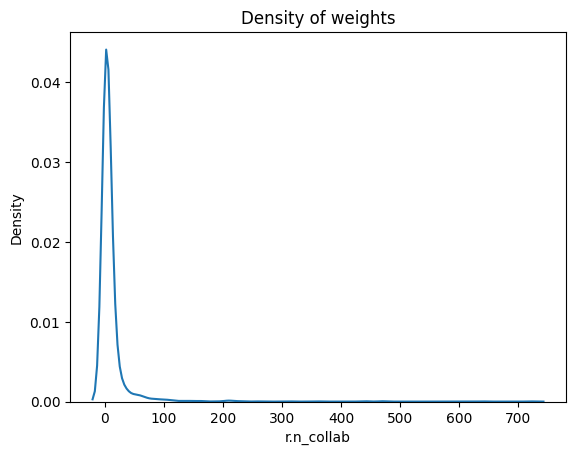

In [25]:
# Does total strength affect collaboration ? seems not like it

# One way is to test if strong heroes have a different density
query = """MATCH (a:Superhero)-[r:RELATION]-(b:Superhero) WHERE a.Total > 480 RETURN a.name,r.n_collab"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["r.n_collab"],hist=False)
ax.title.set_text("Density of weights")

In [26]:
# Sometimes delete all can be slow, remove one by one this way:
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """
MATCH(p:Superhero)
WITH count(p) AS n_node
RETURN n_node
"""

data = graph.run(query)
n_node = next(data)["n_node"]

query = """
MATCH(p:Superhero)
RETURN p.id_
"""

# Returns a generator
data = graph.run(query)

#iterate through all elements
iteration = 0
pbar = tqdm.tqdm(total=n_node)

for i in range(n_node):
    Superhero = next(data)
    query = """
    MATCH (p:Superhero) 
    WHERE p.id_ = {}
    DETACH DELETE p
    """.format(Superhero["p.id_"])
    iteration += 1
    pbar.update(1)
    graph.run(query)


100%|█████████▉| 1169/1170 [00:28<00:00, 54.62it/s]

100%|██████████| 1170/1170 [00:40<00:00, 54.62it/s]

### Exercises

#### CRUD operations:


**1**: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

**2**: How many have collaborated atleast more than 10 times with another superhero?

**3**: Did the weakest of the MCU collaborated with the strongest ?

**4**: Give a stats that interests you !

**5**: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

**6**: Get the age for people YOU collaborate with.

**7**: Get nodes with age > 25.

### Real world problem:

**8**: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

**9**: Get the density of degrees of the collaboration network

**10**: Do a for loop for i in range(500) for each i remove nodes with a degree less than i.


### Real World application 3

You will work again on [pubmed_last_100k.json](https://we.tl/t-6afLCDGRsg). The goal in this homework is to insert collaboration data in Neo4j and then study it using cypher queries. The following questions are meant to guide you through the process.

1) Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

2) How many authors have more than 2 affiliations ?

3) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

4) Which country has seen the most international collaboration ?

5) Who are the top 10 collaborators and what is their affiliation ?

6) Sandbox exercise: think of a problematic and try to answer it.

### Real World application 4

change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. Answer the following questions with cypher queries.

1) How many actors played in more than 2 movie ? Get their names and year they were born.

2) In how many movies did Tom hanks play ?

3) In average in how many movies do actors play in ?

4) In average how many actors are there in a movie ?

5) In average how many writers is needed to write a movie ?

6) What is the proportion of writers that also directed the movie ?

7) Do an histogram of the year of release for the movies.

8) Who are the 10 actors with the most movie played in

9) Delete every movie made by a director of your choosing

10) Give some statistics that you find interesting.

11) Sandbox exercise: think of a problematic and try to answer it.

## Homework 5

You will work on a Twitch dataset found [here](https://www.kaggle.com/andreagarritano/twitch-social-networks). The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node
from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

1) Give the IDs of the top 10 streamers that have atleast one collaboration.

2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

3) How many streamers has the tag "mature" ?

4) Is the collaboration correlated to the "mature" tag ?

5) Do partners collaborate more than non partners ?

6) Sandbox exercise: think of a problematic and try to answer it.


## Homework 6 

You will work on a stackoverflow dataset found [here](https://www.kaggle.com/stackoverflow/stack-overflow-tag-network). First thing to do is create the network on Neo4j. You can find the characteristics of the nodes in stack_network_nodes.csv.
Once the node are create you can create the edges between them, you can find them in stack_network_links.csv. The weight of the edge is the column value. Answer the following making use of cypher queries.

1) What are the 10 most popular keywords ?

2) What are the top 10 Co-occurence ?

3) How many keywords are in group 1 ?

3) Is the Co-occurence correlated to the "group" of the keyword ?  

4) Sandbox exercise: think of a problematic and try to answer it.